In [1]:
import phate
import scprep
import seaborn as sns
import os
import json
from PIL import Image, ImageDraw
import re
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import tifffile as tiff
from tqdm import tqdm
from skimage.exposure import equalize_adapthist
from scipy.stats import stats
import matplotlib.animation as animation
import pandas as pd
import csv
import shutil
from skimage.morphology import dilation, erosion
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import measure
from skimage.measure import regionprops, label
from scipy.spatial import distance
import time
import datetime
from mpl_toolkits.mplot3d import Axes3D  # 3D Plotting
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score



In [4]:
# Generate random data
data = np.random.rand(100, 10)

# Apply PHATE dimensionality reduction
phate_operator = phate.PHATE()
phate_embedding = phate_operator.fit_transform(data)

# Print the shape of the output
print("PHATE embedding shape:", phate_embedding.shape)

Calculating PHATE...
  Running PHATE on 100 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 0.07 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.02 seconds.
Calculated PHATE in 0.10 seconds.
PHATE embedding shape: (100, 2)


Found 100 mask files.
Execution Time: 22.31 seconds
Optimal PCA components to retain 95% variance: 6
PCA Variance Explained with 6 components: 0.9829
Calculating PHATE...
  Running PHATE on 921 observations and 6 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.05 seconds.
  Calculating optimal t...
    Automatically selected t = 18
  Calculated optimal t in 0.14 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.02 seconds.
  Calculating metric MDS...


/home/MinaHossain/.local/lib/python3.12/site-packages/graphtools/graphs.py:283: RuntimeWarning: Detected zero distance between samples 728 and 730. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


  Calculated metric MDS in 0.42 seconds.
Calculated PHATE in 0.64 seconds.


<Figure size 700x500 with 0 Axes>

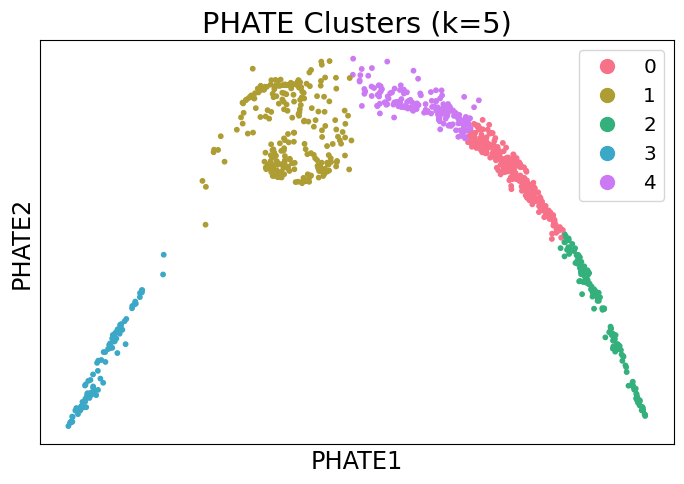

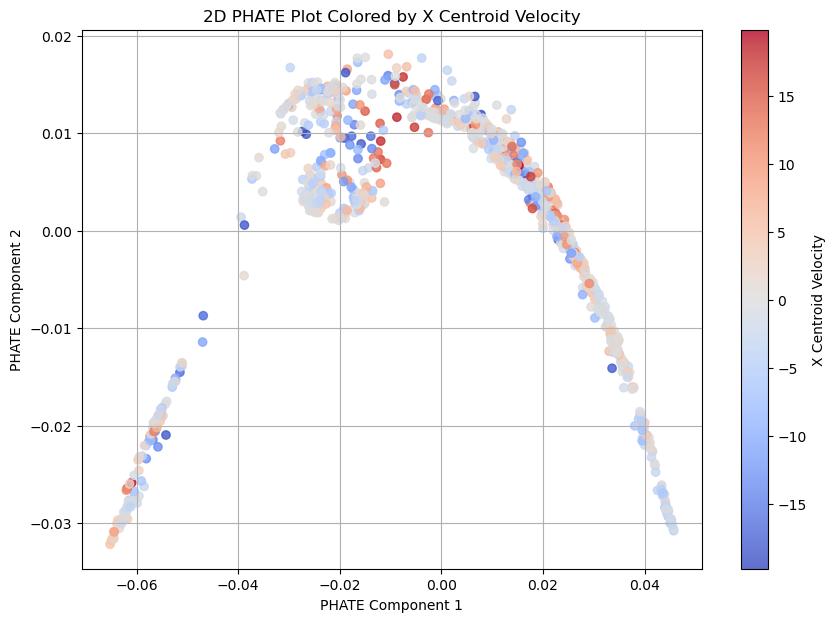

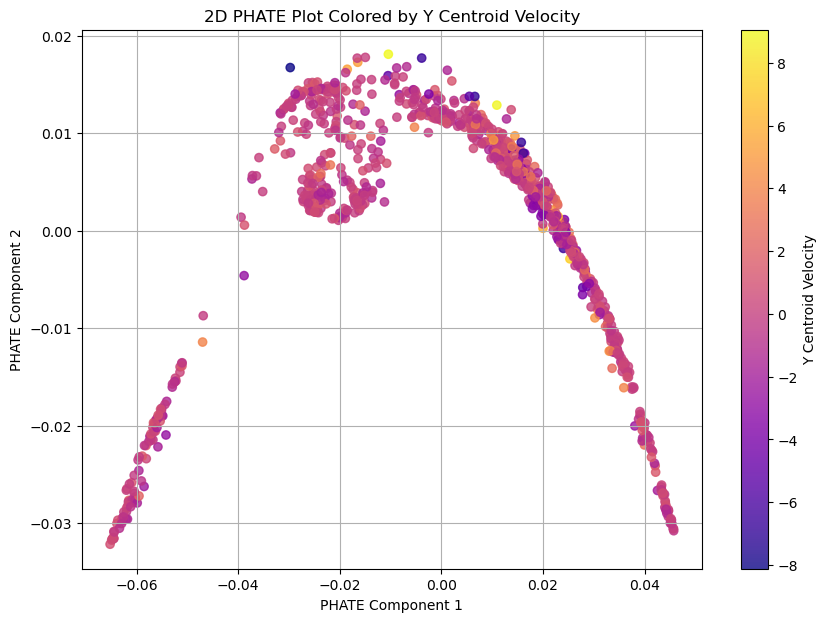

     PHATE1    PHATE2  Cell Number  X_Centroid_Velocity  Y_Centroid_Velocity  \
0  0.032044 -0.008232            2             0.000000             0.000000   
1  0.034710 -0.011485            2             0.949587             1.202573   
2  0.032696 -0.009521            2            -0.704677            -1.680115   
3  0.024382  0.000434            2             0.791966             3.398835   
4  0.021689  0.003675            2            -2.471720             3.408832   
5  0.024002 -0.001821            2            -1.120861            -6.641442   
6  0.027586 -0.003503            2             1.323739             2.847595   
7  0.028294 -0.003964            2             0.616535            -1.139565   
8  0.030380 -0.006272            2            -0.513104             1.314219   
9  0.012235  0.008045            2            -7.523509            -0.104480   

   Cluster  
0        2  
1        2  
2        2  
3        0  
4        0  
5        0  
6        0  
7        0  
8 

In [5]:
def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
    previous_frames = {}  # {Cell_ID: prev_frame}

    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = centroid[0] - prev_centroid[0]  # Keep sign
                    y_dist = centroid[1] - prev_centroid[1]  # Keep sign
                    if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = centroid[0] - prev_x  # Keep sign
                y_centroid_distance = centroid[1] - prev_y  # Keep sign
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
    # Ensure inclusion of cells appearing in at least 3 frames
    frame_counts = df.groupby("Cell Number")["Frame"].nunique()
    valid_cells = frame_counts[frame_counts >= 5].index
    df = df[df["Cell Number"].isin(valid_cells)].sort_values(by=["Cell Number", "Frame"])

    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4_Sign_pHATE5-{timestamp}.csv")
    df.to_csv(csv_path, index=False)
    
    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return csv_path




# def apply_tsne(csv_path, variance_threshold=0.95, tsne_perplexity=30):
#     """Load CSV, apply PCA for variance retention, then use t-SNE for 2D visualization."""
    
#     # Load data
#     df = pd.read_csv(csv_path)
    
#     # Select relevant numeric features
#     selected_columns = ["Cell Number", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
#                         "Elongation", "Circularity", "Convexity", "X_Centroid_Velocity", "Y_Centroid_Velocity"]
    
#     mini_df = df[selected_columns].copy()
    
#     # Drop 'Cell Number' for feature scaling
#     feature_cols = mini_df.drop(columns=["Cell Number"]).columns.tolist()

#     # Standardize features
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(mini_df[feature_cols])

#     # Apply PCA for variance explanation
#     pca = PCA()
#     pca.fit(X_scaled)
    
#     explained_variance = pca.explained_variance_ratio_
#     cumulative_variance = np.cumsum(explained_variance)  # Cumulative variance

#     # Determine the optimal number of components dynamically
#     optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

#     print(f"Optimal PCA components to retain {variance_threshold * 100:.0f}% variance: {optimal_components}")

#     # Apply PCA with optimal components
#     pca = PCA(n_components=optimal_components)
#     X_pca = pca.fit_transform(X_scaled)

#     print(f"PCA Variance Explained with {optimal_components} components: {np.sum(pca.explained_variance_ratio_):.4f}")

#     # Apply t-SNE
#     tsne = TSNE(n_components=2, perplexity=tsne_perplexity, random_state=44)
#     X_tsne = tsne.fit_transform(X_pca)

#     # Convert to DataFrame
#     tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
#     tsne_df["Cell Number"] = mini_df["Cell Number"]
#     tsne_df["X_Centroid_Velocity"] = mini_df["X_Centroid_Velocity"]
#     tsne_df["Y_Centroid_Velocity"] = mini_df["Y_Centroid_Velocity"]

#     # 2D t-SNE Scatter Plot Colored by X_Centroid_Velocity
#     plt.figure(figsize=(10, 7))
#     sc = plt.scatter(tsne_df["TSNE1"], tsne_df["TSNE2"], c=tsne_df["X_Centroid_Velocity"], cmap='coolwarm', alpha=0.8)
#     plt.colorbar(sc, label="X Centroid Velocity")
#     plt.title("2D t-SNE Plot Colored by X Centroid Velocity")
#     plt.xlabel("t-SNE Component 1")
#     plt.ylabel("t-SNE Component 2")
#     plt.grid(True)

#     # Add cell number annotations
#     # for i, txt in enumerate(tsne_df["Cell Number"]):
#     #     plt.text(tsne_df["TSNE1"].iloc[i], tsne_df["TSNE2"].iloc[i], str(txt), fontsize=5, color='black')
#     plt.savefig(os.path.join(output_directory, "t-SNE Plot Colored by X-Centroid_Velocity.png"))
#     plt.show()

#     # 2D t-SNE Scatter Plot Colored by Y_Centroid_Velocity
#     plt.figure(figsize=(10, 7))
#     sc_y = plt.scatter(tsne_df["TSNE1"], tsne_df["TSNE2"], c=tsne_df["Y_Centroid_Velocity"], cmap='plasma', alpha=0.8)
#     plt.colorbar(sc_y, label="Y Centroid Velocity")
#     plt.title("2D t-SNE Plot Colored by Y Centroid Velocity")
#     plt.xlabel("t-SNE Component 1")
#     plt.ylabel("t-SNE Component 2")
#     plt.grid(True)

#     # Add cell number annotations
#     # for i, txt in enumerate(tsne_df["Cell Number"]):
#     #     plt.text(tsne_df["TSNE1"].iloc[i], tsne_df["TSNE2"].iloc[i], str(txt), fontsize=5, color='black')
#     plt.savefig(os.path.join(output_directory, "t-SNE Plot Colored by Y-Centroid_Velocity.png"))
#     plt.show()

#     return tsne_df



# Run the analysis
# mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
# output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"
# csv_file = analyze_cells_across_frames(mask_directory, output_directory)

# # Apply PCA first, then t-SNE
# apply_pca(csv_file)
# tsne_results = apply_tsne(csv_file)

# # Display the first few rows
# print(tsne_results.head(10))

# import phate
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# def apply_phate(csv_path, variance_threshold=0.95):
#     """Load CSV, apply PCA for variance retention, then use PHATE for 2D visualization."""
    
#     # Load data
#     df = pd.read_csv(csv_path)
    
#     # Select relevant numeric features
#     selected_columns = ["Cell Number", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
#                         "Elongation", "Circularity", "Convexity", "X_Centroid_Velocity", "Y_Centroid_Velocity"]
    
#     mini_df = df[selected_columns].copy()
    
#     # Drop 'Cell Number' for feature scaling
#     feature_cols = mini_df.drop(columns=["Cell Number"]).columns.tolist()

#     # Standardize features
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(mini_df[feature_cols])

#     # Apply PCA for variance explanation
#     pca = PCA()
#     pca.fit(X_scaled)
    
#     explained_variance = pca.explained_variance_ratio_
#     cumulative_variance = np.cumsum(explained_variance)  # Cumulative variance

#     # Determine the optimal number of components dynamically
#     optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

#     print(f"Optimal PCA components to retain {variance_threshold * 100:.0f}% variance: {optimal_components}")

#     # Apply PCA with optimal components
#     pca = PCA(n_components=optimal_components)
#     X_pca = pca.fit_transform(X_scaled)

#     print(f"PCA Variance Explained with {optimal_components} components: {np.sum(pca.explained_variance_ratio_):.4f}")

#     # Apply PHATE
#     phate_operator = phate.PHATE(n_components=2, knn=30, random_state=44)
#     X_phate = phate_operator.fit_transform(X_pca)

#     # Convert to DataFrame
#     phate_df = pd.DataFrame(X_phate, columns=["PHATE1", "PHATE2"])
#     phate_df["Cell Number"] = mini_df["Cell Number"]
#     phate_df["X_Centroid_Velocity"] = mini_df["X_Centroid_Velocity"]
#     phate_df["Y_Centroid_Velocity"] = mini_df["Y_Centroid_Velocity"]

#     # 2D PHATE Scatter Plot Colored by X_Centroid_Velocity
#     plt.figure(figsize=(10, 7))
#     sc = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"], c=phate_df["X_Centroid_Velocity"], cmap='hsv', alpha=0.8)
#     plt.colorbar(sc, label="X Centroid Velocity")
#     plt.title("2D PHATE Plot Colored by X Centroid Velocity")
#     plt.xlabel("PHATE Component 1")
#     plt.ylabel("PHATE Component 2")
#     plt.grid(True)
#     plt.savefig(os.path.join(output_directory, "PHATE Plot Colored by X-Centroid_Velocity.png"))
#     plt.show()

#     # 2D PHATE Scatter Plot Colored by Y_Centroid_Velocity
    
#     # cmap='plasma'
#     plt.figure(figsize=(10, 7))
#     sc_y = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"], c=phate_df["Y_Centroid_Velocity"],cmap="CMRmap_r" , alpha=0.8)
#     plt.colorbar(sc_y, label="Y Centroid Velocity")
#     plt.title("2D PHATE Plot Colored by Y Centroid Velocity")
#     plt.xlabel("PHATE Component 1")
#     plt.ylabel("PHATE Component 2")
#     plt.grid(True)
#     plt.savefig(os.path.join(output_directory, "PHATE Plot Colored by Y-Centroid_Velocity.png"))
#     plt.show()

#     return phate_df




def apply_phate(csv_path, variance_threshold=0.95, k_clusters=5):
    """Load CSV, apply PCA for variance retention, use PHATE for 2D visualization, and apply k-means clustering."""
    
    # Load data
    df = pd.read_csv(csv_path)
    
    # Select relevant numeric features
    selected_columns = ["Cell Number", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
                        "Elongation", "Circularity", "Convexity", "X_Centroid_Velocity", "Y_Centroid_Velocity"]
    
    mini_df = df[selected_columns].copy()
    
    # Drop 'Cell Number' for feature scaling
    feature_cols = mini_df.drop(columns=["Cell Number"]).columns.tolist()

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(mini_df[feature_cols])

    # Apply PCA for variance explanation
    pca = PCA()
    pca.fit(X_scaled)
    
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)  # Cumulative variance

    # Determine the optimal number of components dynamically
    optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    print(f"Optimal PCA components to retain {variance_threshold * 100:.0f}% variance: {optimal_components}")

    # Apply PCA with optimal components
    pca = PCA(n_components=optimal_components)
    X_pca = pca.fit_transform(X_scaled)

    print(f"PCA Variance Explained with {optimal_components} components: {np.sum(pca.explained_variance_ratio_):.4f}")

    # Apply PHATE
    phate_operator = phate.PHATE(n_components=2, knn=30, random_state=44)
    X_phate = phate_operator.fit_transform(X_pca)

    # Convert to DataFrame
    phate_df = pd.DataFrame(X_phate, columns=["PHATE1", "PHATE2"])
    phate_df["Cell Number"] = mini_df["Cell Number"]
    phate_df["X_Centroid_Velocity"] = mini_df["X_Centroid_Velocity"]
    phate_df["Y_Centroid_Velocity"] = mini_df["Y_Centroid_Velocity"]

    # Apply k-means clustering on PHATE embedding
    kmeans = KMeans(n_clusters=k_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_phate)
    phate_df["Cluster"] = clusters

    # 2D PHATE Scatter Plot Colored by Clusters
    plt.figure(figsize=(7, 5))
    scprep.plot.scatter2d(
        X_phate, c=clusters, cmap=sns.husl_palette(k_clusters), s=10,
        figsize=(7,5), ticks=None, label_prefix='PHATE',
        legend_anchor=(1,1), fontsize=12, title=f'PHATE Clusters (k={k_clusters})'
    )
    plt.savefig(os.path.join(output_directory, f"PHATE_Clusters_k{k_clusters}.png"))
    plt.show()

    # 2D PHATE Scatter Plot Colored by X_Centroid_Velocity
    plt.figure(figsize=(10, 7))
    sc = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"], c=phate_df["X_Centroid_Velocity"], cmap='coolwarm', alpha=0.8)
    plt.colorbar(sc, label="X Centroid Velocity")
    plt.title("2D PHATE Plot Colored by X Centroid Velocity")
    plt.xlabel("PHATE Component 1")
    plt.ylabel("PHATE Component 2")
    plt.grid(True)
    plt.savefig(os.path.join(output_directory, "PHATE Plot Colored by X-Centroid_Velocity.png"))
    plt.show()

    # 2D PHATE Scatter Plot Colored by Y_Centroid_Velocity
    plt.figure(figsize=(10, 7))
    sc_y = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"], c=phate_df["Y_Centroid_Velocity"], cmap='plasma', alpha=0.8)
    plt.colorbar(sc_y, label="Y Centroid Velocity")
    plt.title("2D PHATE Plot Colored by Y Centroid Velocity")
    plt.xlabel("PHATE Component 1")
    plt.ylabel("PHATE Component 2")
    plt.grid(True)
    plt.savefig(os.path.join(output_directory, "PHATE Plot Colored by Y-Centroid_Velocity.png"))
    plt.show()

    return phate_df



# Run the analysis
mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"
csv_file = analyze_cells_across_frames(mask_directory, output_directory)

# Apply PCA first, then PHATE
phate_results = apply_phate(csv_file)

# Display the first few rows
print(phate_results.head(10))




# pHATE link: https://dburkhardt.github.io/tutorial/visualizing_phate/#:~:text=PHATE%20was%20designed%20to%20handle,cells%20present%20in%20a%20dataset.

Found 100 mask files.
Execution Time: 22.42 seconds
Optimal PCA components to retain 95% variance: 5
PCA Variance Explained with 5 components: 0.9610
Calculating PHATE...
  Running PHATE on 45 observations and 5 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 4
  Calculating diffusion potential...
  Calculating metric MDS...


<Figure size 700x500 with 0 Axes>

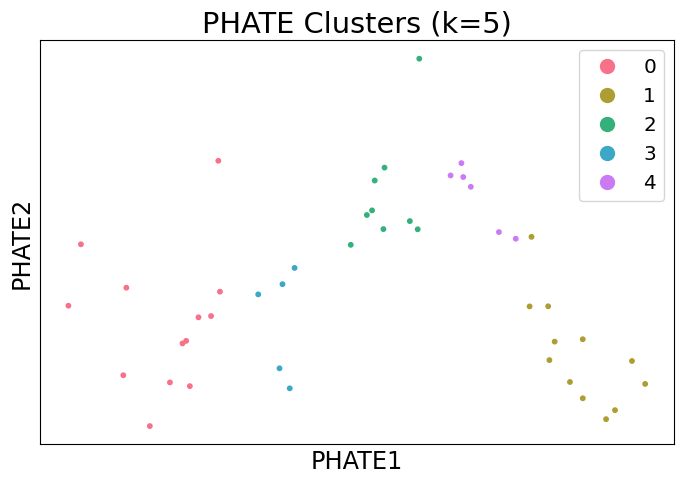

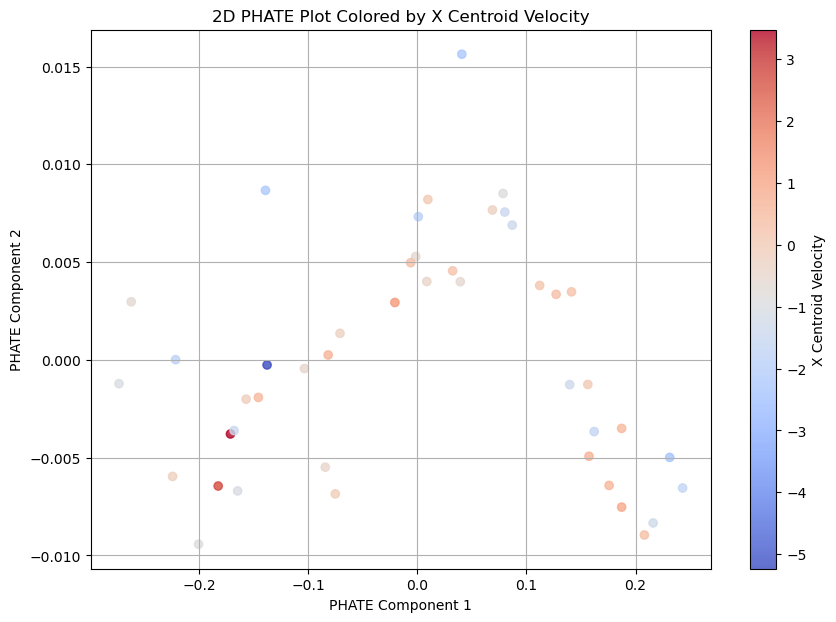

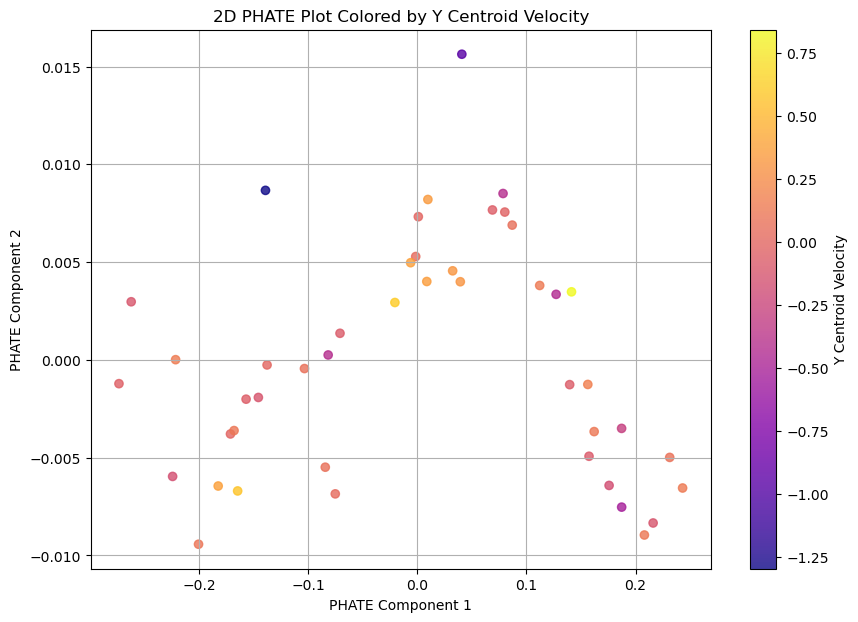

     PHATE1    PHATE2  Cell Number  X_Centroid_Velocity  Y_Centroid_Velocity  \
0  0.208053 -0.008953            2             0.316395             0.118936   
1  0.080163  0.007562            3            -1.456884            -0.028068   
2  0.032368  0.004557            4             0.221896             0.309386   
3 -0.171197 -0.003786            5             3.479191            -0.013923   
4  0.112121  0.003807            6             0.134266             0.130355   
5  0.231255 -0.004985            7            -2.389766             0.080050   
6 -0.200457 -0.009425            8            -0.889045             0.099279   
7 -0.167910 -0.003613            9            -1.456256             0.108436   
8  0.086957  0.006895           10            -1.369831             0.059488   
9  0.243057 -0.006550           11            -1.670129             0.125869   

   Cluster  
0        1  
1        4  
2        2  
3        0  
4        4  
5        1  
6        0  
7        0  
8 

In [4]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
    previous_frames = {}  # {Cell_ID: prev_frame}

    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = centroid[0] - prev_centroid[0]  # Keep sign
                    y_dist = centroid[1] - prev_centroid[1]  # Keep sign
                    if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = centroid[0] - prev_x  # Keep sign
                y_centroid_distance = centroid[1] - prev_y  # Keep sign
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
    # Ensure inclusion of cells appearing in at least 3 frames
    frame_counts = df.groupby("Cell Number")["Frame"].nunique()
    valid_cells = frame_counts[frame_counts >= 5].index
    df = df[df["Cell Number"].isin(valid_cells)].sort_values(by=["Cell Number", "Frame"])

    avg_df = df.groupby("Cell Number").mean().reset_index()  #### Get the Average by Cell ID


    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4_Sign_Avg_pHATE5-{timestamp}.csv")
    avg_df.to_csv(csv_path, index=False)
    
    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return csv_path




def apply_phate(csv_path, variance_threshold=0.95, k_clusters=5):
    """Load CSV, apply PCA for variance retention, use PHATE for 2D visualization, and apply k-means clustering."""
    
    # Load data
    df = pd.read_csv(csv_path)
    
    # Select relevant numeric features
    selected_columns = ["Cell Number", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
                        "Elongation", "Circularity", "Convexity", "X_Centroid_Velocity", "Y_Centroid_Velocity"]
    
    mini_df = df[selected_columns].copy()
    
    # Drop 'Cell Number' for feature scaling
    feature_cols = mini_df.drop(columns=["Cell Number"]).columns.tolist()

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(mini_df[feature_cols])

    # Apply PCA for variance explanation
    pca = PCA()
    pca.fit(X_scaled)
    
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)  # Cumulative variance

    # Determine the optimal number of components dynamically
    optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    print(f"Optimal PCA components to retain {variance_threshold * 100:.0f}% variance: {optimal_components}")

    # Apply PCA with optimal components
    pca = PCA(n_components=optimal_components)
    X_pca = pca.fit_transform(X_scaled)

    print(f"PCA Variance Explained with {optimal_components} components: {np.sum(pca.explained_variance_ratio_):.4f}")

    # Apply PHATE
    phate_operator = phate.PHATE(n_components=2, knn=30, random_state=44)
    X_phate = phate_operator.fit_transform(X_pca)

    # Convert to DataFrame
    phate_df = pd.DataFrame(X_phate, columns=["PHATE1", "PHATE2"])
    phate_df["Cell Number"] = mini_df["Cell Number"]
    phate_df["X_Centroid_Velocity"] = mini_df["X_Centroid_Velocity"]
    phate_df["Y_Centroid_Velocity"] = mini_df["Y_Centroid_Velocity"]

    # Apply k-means clustering on PHATE embedding
    kmeans = KMeans(n_clusters=k_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_phate)
    phate_df["Cluster"] = clusters

    # 2D PHATE Scatter Plot Colored by Clusters
    plt.figure(figsize=(7, 5))
    scprep.plot.scatter2d(
        X_phate, c=clusters, cmap=sns.husl_palette(k_clusters), s=10,
        figsize=(7,5), ticks=None, label_prefix='PHATE',
        legend_anchor=(1,1), fontsize=12, title=f'PHATE Clusters (k={k_clusters})'
    )
    plt.savefig(os.path.join(output_directory, f"PHATE_Clusters_k_AVG{k_clusters}.png"))
    plt.show()

    # 2D PHATE Scatter Plot Colored by X_Centroid_Velocity
    plt.figure(figsize=(10, 7))
    sc = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"], c=phate_df["X_Centroid_Velocity"], cmap='coolwarm', alpha=0.8)
    plt.colorbar(sc, label="X Centroid Velocity")
    plt.title("2D PHATE Plot Colored by X Centroid Velocity")
    plt.xlabel("PHATE Component 1")
    plt.ylabel("PHATE Component 2")
    plt.grid(True)
    plt.savefig(os.path.join(output_directory, "PHATE Plot Colored by X-Centroid_Velocity_AVG.png"))
    plt.show()

    # 2D PHATE Scatter Plot Colored by Y_Centroid_Velocity
    plt.figure(figsize=(10, 7))
    sc_y = plt.scatter(phate_df["PHATE1"], phate_df["PHATE2"], c=phate_df["Y_Centroid_Velocity"], cmap='plasma', alpha=0.8)
    plt.colorbar(sc_y, label="Y Centroid Velocity")
    plt.title("2D PHATE Plot Colored by Y Centroid Velocity")
    plt.xlabel("PHATE Component 1")
    plt.ylabel("PHATE Component 2")
    plt.grid(True)
    plt.savefig(os.path.join(output_directory, "PHATE Plot Colored by Y-Centroid_Velocity_AVG.png"))
    plt.show()

    return phate_df



# Run the analysis
mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"
csv_file = analyze_cells_across_frames(mask_directory, output_directory)

# Apply PCA first, then PHATE
phate_results = apply_phate(csv_file)

# Display the first few rows
print(phate_results.head(10))




Found 100 mask files.
Execution Time: 23.05 seconds

🔍 Data Preview:
   Cell Number      Frame          Area    Perimeter    Extent  Solidity  \
0            2  35.672414  18930.275862   759.061003  0.800731  0.582872   
1            3  39.848485  37528.939394  1134.121025  0.854049  0.609130   
2            4  52.514286  34596.928571  1252.092828  0.786126  0.583956   
3            6  23.227273  28129.159091  1018.277108  0.817052  0.542855   
4            8  59.897436  71921.256410  2279.526839  0.736359  0.647871   

   Compactness  Elongation  Circularity  Convexity   Centroid_X   Centroid_Y  \
0     0.421937    0.917817     0.600165   0.565028  1308.226014    98.919978   
1     0.375052    0.940753     0.738383   0.482008  1010.674508   105.553358   
2     0.288701    0.839349     0.703481   0.483310  1280.263537   695.048224   
3     0.354858    0.935325     0.652546   0.534727   781.543840  1279.502788   
4     0.185092    0.799518     0.840268   0.359866  1131.308669  1879.4645

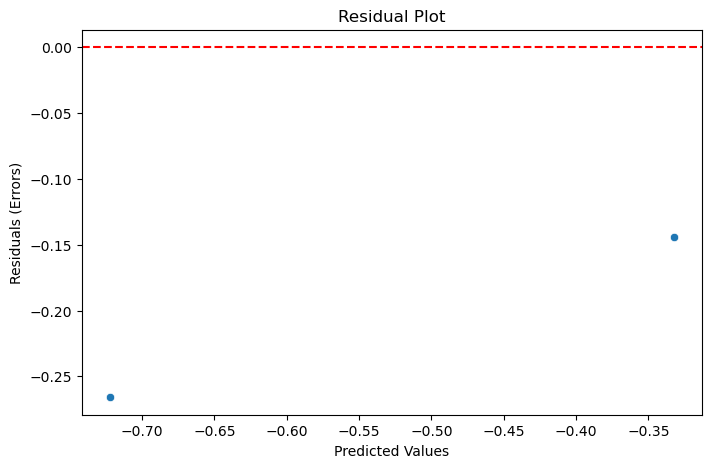

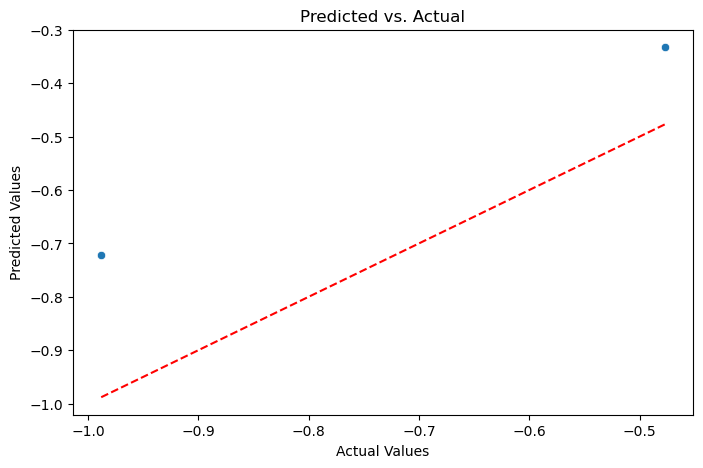

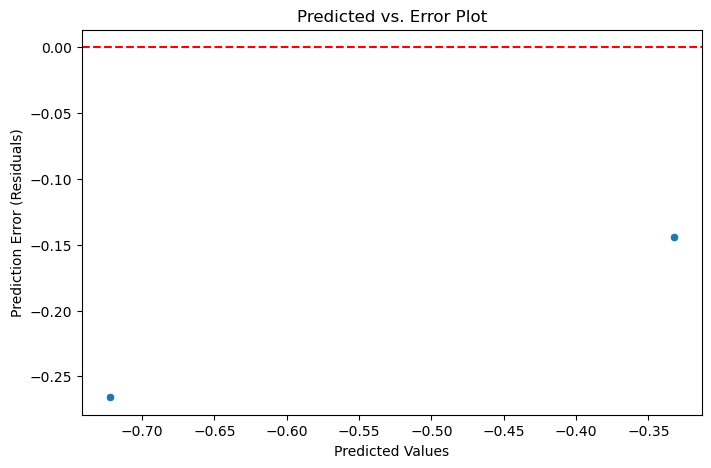


📊 Final Model Coefficients:
Area: -0.000015
Perimeter: 0.000247
Extent: -0.162576
Solidity: -0.100435
Compactness: -0.087718
Elongation: -0.168608
Circularity: -0.162912
Convexity: 0.101432

📊 Model Performance:
Mean Squared Error (MSE): 0.0458
R-squared: 0.2985

📊 Train-Test Split Shapes:
X_train shape: (11, 8), X_test shape: (2, 8)
y_train shape: (11,), y_test shape: (2,)


Ridge()

In [15]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
    previous_frames = {}  # {Cell_ID: prev_frame}

    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = centroid[0] - prev_centroid[0]  # Keep sign
                    y_dist = centroid[1] - prev_centroid[1]  # Keep sign
                    if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = centroid[0] - prev_x  # Keep sign
                y_centroid_distance = centroid[1] - prev_y  # Keep sign
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
    # Ensure inclusion of cells appearing in at least 3 frames
    frame_counts = df.groupby("Cell Number")["Frame"].nunique()
    valid_cells = frame_counts[frame_counts >= 20].index
    df = df[df["Cell Number"].isin(valid_cells)].sort_values(by=["Cell Number", "Frame"])

    avg_df = df.groupby("Cell Number").mean().reset_index()  #### Get the Average by Cell ID


    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4_Sign_REG20-{timestamp}.csv")
    avg_df.to_csv(csv_path, index=False)
    
    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return csv_path




# def apply_tsne(csv_path, variance_threshold=0.95, tsne_perplexity=30):
#     """Load CSV, apply PCA for variance retention, then use t-SNE for 2D visualization."""
    
#     # Load data
#     df = pd.read_csv(csv_path)
    
#     # Select relevant numeric features
#     selected_columns = ["Cell Number", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
#                         "Elongation", "Circularity", "Convexity", "X_Centroid_Velocity", "Y_Centroid_Velocity"]
    
#     mini_df = df[selected_columns].copy()
    
#     # Drop 'Cell Number' for feature scaling
#     feature_cols = mini_df.drop(columns=["Cell Number"]).columns.tolist()

#     # Standardize features
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(mini_df[feature_cols])

#     # Apply PCA for variance explanation
#     pca = PCA()
#     pca.fit(X_scaled)
    
#     explained_variance = pca.explained_variance_ratio_
#     cumulative_variance = np.cumsum(explained_variance)  # Cumulative variance

#     # Determine the optimal number of components dynamically
#     optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

#     print(f"Optimal PCA components to retain {variance_threshold * 100:.0f}% variance: {optimal_components}")

#     # Apply PCA with optimal components
#     pca = PCA(n_components=optimal_components)
#     X_pca = pca.fit_transform(X_scaled)

#     print(f"PCA Variance Explained with {optimal_components} components: {np.sum(pca.explained_variance_ratio_):.4f}")

#     # Apply t-SNE
#     tsne = TSNE(n_components=2, perplexity=tsne_perplexity, random_state=44)
#     X_tsne = tsne.fit_transform(X_pca)

#     # Convert to DataFrame
#     tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
#     tsne_df["Cell Number"] = mini_df["Cell Number"]
#     tsne_df["X_Centroid_Velocity"] = mini_df["X_Centroid_Velocity"]
#     tsne_df["Y_Centroid_Velocity"] = mini_df["Y_Centroid_Velocity"]

#     # 2D t-SNE Scatter Plot Colored by X_Centroid_Velocity
#     plt.figure(figsize=(10, 7))
#     sc = plt.scatter(tsne_df["TSNE1"], tsne_df["TSNE2"], c=tsne_df["X_Centroid_Velocity"], cmap='coolwarm', alpha=0.8)
#     plt.colorbar(sc, label="X Centroid Velocity")
#     plt.title("2D t-SNE Plot Colored by X Centroid Velocity Avg by Cell Id")
#     plt.xlabel("t-SNE Component 1")
#     plt.ylabel("t-SNE Component 2")
#     plt.grid(True)

#     # Add cell number annotations
#     # for i, txt in enumerate(tsne_df["Cell Number"]):
#     #     plt.text(tsne_df["TSNE1"].iloc[i], tsne_df["TSNE2"].iloc[i], str(txt), fontsize=5, color='black')
#     plt.savefig(os.path.join(output_directory, "t-SNE Plot Colored by X-Centroid_Velocity Avg by Cell Id.png"))
#     plt.show()

#     # 2D t-SNE Scatter Plot Colored by Y_Centroid_Velocity
#     plt.figure(figsize=(10, 7))
#     sc_y = plt.scatter(tsne_df["TSNE1"], tsne_df["TSNE2"], c=tsne_df["Y_Centroid_Velocity"], cmap='plasma', alpha=0.8)
#     plt.colorbar(sc_y, label="Y Centroid Velocity")
#     plt.title("2D t-SNE Plot Colored by Y Centroid Velocity Avg by Cell Id")
#     plt.xlabel("t-SNE Component 1")
#     plt.ylabel("t-SNE Component 2")
#     plt.grid(True)

#     # Add cell number annotations
#     # for i, txt in enumerate(tsne_df["Cell Number"]):
#     #     plt.text(tsne_df["TSNE1"].iloc[i], tsne_df["TSNE2"].iloc[i], str(txt), fontsize=5, color='black')

#     plt.savefig(os.path.join(output_directory, "t-SNE Plot Colored by Y-Centroid_Velocity Avg by Cell Id.png"))
#     plt.show()

#     return tsne_df

# def run_regression_analysis(csv_path):
#     """Performs multiple linear regression to predict X_Centroid_Velocity while handling statistical issues."""

#     # Load dataset
#     df = pd.read_csv(csv_path)

#     # Features and Target
#     features = ["Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity"]
#     target = "X_Centroid_Velocity"

#     # Ensure required columns exist
#     for col in features + [target]:
#         if col not in df.columns:
#             raise ValueError(f"Missing column in dataset: {col}")

#     X = df[features]
#     y = df[target]

#     # Train-Test Split (90%-10%)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#     # Debugging: Print shapes to ensure data is not empty
#     print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

#     if X_train.empty or y_train.empty:
#         raise ValueError("Error: X_train or y_train is empty. Check data preprocessing.")

#     # ✅ Step 3: Multicollinearity Test (VIF)
#     vif_data = pd.DataFrame()
#     vif_data["Feature"] = X_train.columns
#     vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

#     # Remove highly correlated features (VIF > 10)
#     high_vif_features = vif_data[vif_data["VIF"] > 10]["Feature"].tolist()
#     if high_vif_features:
#         print(f"Removing high VIF features: {high_vif_features}")
#         X_train = X_train.drop(columns=high_vif_features)
#         X_test = X_test.drop(columns=high_vif_features)

#     # Ensure data is still valid after VIF removal
#     if X_train.empty:
#         raise ValueError("Error: All features were removed due to high VIF. Consider keeping some features.")

#     # ✅ Step 4: Train Multiple Linear Regression Model
#     model = LinearRegression()
#     model.fit(X_train, y_train)

#     # ✅ Step 5: Model Evaluation
#     y_pred = model.predict(X_test)
#     mse = np.mean((y_test - y_pred) ** 2)
#     r2 = model.score(X_test, y_test)

#     # ✅ Step 6: Print Model Results
#     print("\nFinal Model Coefficients:")
#     for feature, coef in zip(X_train.columns, model.coef_):
#         print(f"{feature}: {coef:.4f}")

#     print("\nModel Performance:")
#     print(f"Mean Squared Error (MSE): {mse:.4f}")
#     print(f"R-squared: {r2:.4f}")




# def run_regression_analysis(csv_path, method="ridge", alpha=1.0):
#     """
#     Applies Ridge or Lasso Regression to predict X_Centroid_Velocity while handling 
#     multicollinearity, heteroscedasticity, and autocorrelation.

#     Parameters:
#         csv_path (str): Path to the CSV file containing cell tracking data.
#         method (str): "ridge" for Ridge Regression or "lasso" for Lasso Regression.
#         alpha (float): Regularization strength (higher = more regularization).
#     """

#     # Load dataset
#     df = pd.read_csv(csv_path)

#     # Define Features and Target Variable
#     features = ["Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity"]
#     target = "X_Centroid_Velocity"

#     # Ensure required columns exist
#     for col in features + [target]:
#         if col not in df.columns:
#             raise ValueError(f"Missing column in dataset: {col}")

#     X = df[features]
#     y = df[target]

#     # Train-Test Split (90%-10%)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#     # Debugging: Print shapes before training
#     print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

#     if X_train.empty or y_train.empty:
#         raise ValueError("Error: X_train or y_train is empty. Check data preprocessing.")

#     # ✅ Step 1: Apply Ridge or Lasso Regression
#     if method.lower() == "ridge":
#         model = Ridge(alpha=alpha)
#         print(f"Applying Ridge Regression with alpha={alpha}")
#     elif method.lower() == "lasso":
#         model = Lasso(alpha=alpha)
#         print(f"Applying Lasso Regression with alpha={alpha}")
#     else:
#         raise ValueError("Invalid method. Choose 'ridge' or 'lasso'.")

#     # Fit the model
#     model.fit(X_train, y_train)

#     # ✅ Step 2: Heteroscedasticity Test (Breusch-Pagan)
#     X_train_const = sm.add_constant(X_train)  # Add constant for statsmodels
#     ols_model = sm.OLS(y_train, X_train_const).fit()
#     _, pval, _, _ = het_breuschpagan(ols_model.resid, X_train_const)

#     print("\nHeteroscedasticity Test (Breusch-Pagan p-value):", pval)

#     # If heteroscedasticity is detected (p-value < 0.05), apply Weighted Least Squares (WLS)
#     if pval < 0.05:
#         print("Heteroscedasticity detected. Applying Weighted Least Squares (WLS)...")
#         wls_model = sm.WLS(y_train, X_train).fit()
#         model = wls_model  # Use WLS instead of Ridge/Lasso

#     # ✅ Step 3: Autocorrelation Test (Durbin-Watson)
#     dw_stat = durbin_watson(ols_model.resid)
#     print("Autocorrelation Test (Durbin-Watson Statistic):", dw_stat)

#     # If autocorrelation is detected, apply Generalized Least Squares (GLS)
#     if dw_stat < 1 or dw_stat > 3:
#         print("Autocorrelation detected. Applying Generalized Least Squares (GLS)...")
#         gls_model = sm.GLS(y_train, X_train).fit()
#         model = gls_model  # Use GLS instead of Ridge/Lasso

#     # ✅ Step 4: Model Evaluation
#     y_pred = model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)

#     # ✅ Step 5: Print Model Results
#     print("\nFinal Model Coefficients:")
#     for feature, coef in zip(X_train.columns, model.params if hasattr(model, 'params') else model.coef_):
#         print(f"{feature}: {coef:.4f}")

#     print("\nModel Performance:")
#     print(f"Mean Squared Error (MSE): {mse:.4f}")
#     print(f"R-squared: {r2:.4f}")

#     return model  # Return the trained model for further use





def run_regression_analysis(csv_path, method="ridge", alpha=1.0):
    """
    Performs regression analysis on X_Centroid_Velocity with Ridge or Lasso regression.

    Parameters:
        csv_path (str): Path to the CSV file.
        method (str): "ridge" for Ridge Regression or "lasso" for Lasso Regression.
        alpha (float): Regularization strength.
    """

    # ✅ Step 1: Load dataset
    df = pd.read_csv(csv_path)

    # ✅ Step 2: Verify Data Integrity
    print("\n🔍 Data Preview:")
    print(df.head())  # Show first few rows

    print("\n📊 Dataset Summary:")
    print(df.describe())  # Show summary statistics

    print("\n🔍 Checking for NaN values:")
    print(df.isnull().sum())  # Check for missing values

    # Define Features and Target Variable
    features = ["Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity"]
    target = "X_Centroid_Velocity"

    # ✅ Step 3: Verify Correlation with Target
    print("\n📊 Correlation with Target Variable:")
    print(df[features + [target]].corr()[target].sort_values(ascending=False))

    # ✅ Step 4: Split into Features & Target
    X = df[features]
    y = df[target]

    # ✅ Step 5: Train-Test Split (90%-10%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    print(f"\n📊 Train-Test Split: X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

    # ✅ Step 6: Apply Ridge or Lasso Regression
    if method.lower() == "ridge":
        model = Ridge(alpha=alpha)
        print(f"\n🚀 Applying Ridge Regression with alpha={alpha}")
    elif method.lower() == "lasso":
        model = Lasso(alpha=alpha)
        print(f"\n🚀 Applying Lasso Regression with alpha={alpha}")
    else:
        raise ValueError("Invalid method. Choose 'ridge' or 'lasso'.")

    # ✅ Step 7: Fit the Model
    model.fit(X_train, y_train)

    # ✅ Step 8: Model Evaluation
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # ✅ Step 9: Baseline Comparison (Mean Model)
    y_mean = np.mean(y_train)
    mse_baseline = mean_squared_error(y_test, np.full_like(y_test, y_mean))
    print(f"\n📊 Baseline Model (Predicting Mean): MSE = {mse_baseline:.4f}")

    # ✅ Step 10: Residual Analysis
    residuals = y_test - y_pred

    # 🔹 Residual Plot
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (Errors)")
    plt.title("Residual Plot")
    plt.show()

    # 🔹 Predicted vs. Actual
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs. Actual")
    plt.show()

    # 🔹 Predicted vs. Error
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Prediction Error (Residuals)")
    plt.title("Predicted vs. Error Plot")
    plt.show()

    # ✅ Step 11: Print Model Results
    print("\n📊 Final Model Coefficients:")
    for feature, coef in zip(features, model.coef_):
        print(f"{feature}: {coef:.6f}")

    print("\n📊 Model Performance:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared: {r2:.4f}")

    print(f"\n📊 Train-Test Split Shapes:")
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


    return model


# Run Analysis
mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"
csv_file = analyze_cells_across_frames(mask_directory, output_directory)
run_regression_analysis(csv_file)


# Run the analysis
# mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
# output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"
# csv_file = analyze_cells_across_frames(mask_directory, output_directory)

# # Apply PCA first, then t-SNE
# apply_pca(csv_file)
# tsne_results = apply_tsne(csv_file)

# # Display the first few rows
# print(tsne_results.head(10))

